In [1]:
import os
import cv2
import sheet_id.deepmatching_cpu.deepmatching as dm
from tqdm import tqdm_notebook as tqdm
from sheet_id.utils.base_utils import loadSettings, loadScoresDataset, loadCellphoneScoresDataset, \
    generateScoresDB, calculateMRR

from matplotlib.patches import ConnectionPatch
from multiprocessing import Pool, freeze_support

In [2]:
settings = loadSettings()

In [3]:
scores_path = loadScoresDataset(settings['DB_PATH'])
cellphone_scores_path = loadCellphoneScoresDataset(settings['CELLPHONE_IMG_PATH'])
db = generateScoresDB(scores_path)

In [ ]:
def imageDistance(img_a, img_b):
    _, img1 = cv2.threshold(img_a,127,255,cv2.THRESH_BINARY)
    _, img2 = cv2.threshold(img_b,127,255,cv2.THRESH_BINARY)
    if img1.shape[0] >= 1000:
        scale1 = 1.0 / (img1.shape[0] // 1000)
        img1 = cv2.resize(img1, (0,0), fx=scale1, fy=scale1)
    if img2.shape[0] >= 1000:
        scale2 = 1.0 / (img2.shape[0] // 1000)
        img2 = cv2.resize(img2, (0,0), fx=scale2, fy=scale2)
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB)
    matches = dm.deepmatching(img1, img2, '-downscale 2 -nt 12' )
    score = len(matches)
    distance = -score
    return distance

In [ ]:
def search(query_img, db):
    """
    Search the query from the db and return the list of predictions ranked by the score in
    the form of 
        (ref_name, distance)
    """
    scoreRanking = []
    for ref in tqdm(db):
        ref_img = db[ref]
        dist = imageDistance(query_img, ref_img)
        scoreRanking.append((ref, dist))
    return sorted(scoreRanking, key=lambda x: x[1]) # Sort based on distance in increasing order 

In [ ]:
def findRank(predictions, ref):
    """
    Find the rank of ref in the list of predictions
    """
    rank = 1
    for (prediction, dist) in predictions:
        if prediction == ref:
            return rank
        rank += 1
    raise ValueError('Ref not found')

In [ ]:
ranks = []
for i in tqdm(range(len(cellphone_scores_path))):
    img = cv2.imread(cellphone_scores_path[i], 0)
    fileNameNoExt = os.path.splitext(os.path.split(cellphone_scores_path[i])[1])[0]
    predictions = search(img, db)
    rank = findRank(predictions, fileNameNoExt)
    ranks.append(rank)
    print("Query {:} [{:}]: {:} [top10={:}]".format(i+1, fileNameNoExt, rank, predictions[:10]))

In [ ]:
MRR = calculateMRR(ranks)
print("MRR: {:}".format(MRR))

# Raw Results

```
Query 1 [01106_page_45]: 1 [top10=[('01106_page_45', -1623), ('415756_page_27', -515), ('295562_page_85', -509), ('515927_page_100', -498), ('514286_page_110', -456), ('458322_page_23', -448), ('517023_page_108', -445), ('01749_page_1', -443), ('330636_page_115', -431), ('01380_page_5', -430)]]

Query 2 [01380_page_5]: 1 [top10=[('01380_page_5', -1537), ('458322_page_23', -523), ('238622_page_16', -520), ('01749_page_1', -519), ('433671_page_7', -491), ('57857_page_22', -477), ('295562_page_85', -466), ('330636_page_115', -463), ('279665_page_680', -458), ('16314_page_29', -455)]]

Query 3 [01685_page_24]: 1 [top10=[('01685_page_24', -1632), ('61784_page_40', -632), ('241869_page_42', -607), ('371085_page_36', -588), ('340340_page_96', -556), ('295562_page_85', -545), ('62251_page_32', -539), ('378078_page_75', -530), ('517423_page_110', -523), ('03031_page_19', -520)]]

Query 4 [01749_page_1]: 1 [top10=[('01749_page_1', -1588), ('305764_page_88', -443), ('371085_page_36', -442), ('35927_page_30', -439), ('16314_page_29', -436), ('01380_page_5', -434), ('238622_page_16', -414), ('27475_page_7', -409), ('02331_page_69', -403), ('63473_page_83', -403)]]

Query 5 [01923_page_10]: 1 [top10=[('01923_page_10', -1071), ('84124_page_22', -603), ('01749_page_1', -566), ('16314_page_29', -526), ('57857_page_22', -522), ('234233_page_19', -519), ('295562_page_85', -518), ('335945_page_113', -518), ('54136_page_56', -495), ('331259_page_26', -492)]]

Query 6 [01938_page_1]: 1 [top10=[('01938_page_1', -1560), ('55127_page_2', -539), ('50532_page_1', -518), ('247445_page_68', -517), ('172491_page_2', -504), ('62251_page_32', -500), ('27475_page_7', -498), ('50754_page_1', -489), ('43238_page_23', -486), ('52189_page_6', -484)]]

Query 7 [02235_page_77]: 1 [top10=[('02235_page_77', -1419), ('335945_page_113', -572), ('234233_page_19', -559), ('01380_page_5', -495), ('433671_page_7', -494), ('340340_page_96', -488), ('331259_page_26', -486), ('61784_page_40', -475), ('80125_page_14', -474), ('251579_page_24', -464)]]

Query 8 [02267_page_2]: 1 [top10=[('02267_page_2', -1212), ('241869_page_42', -603), ('62251_page_32', -603), ('80125_page_14', -585), ('458322_page_23', -544), ('335945_page_113', -528), ('340340_page_96', -527), ('218668_page_32', -512), ('295562_page_85', -511), ('517023_page_108', -508)]]

Query 9 [02331_page_69]: 1 [top10=[('02331_page_69', -1600), ('27475_page_7', -633), ('415756_page_27', -620), ('06563_page_14', -615), ('57857_page_22', -579), ('279985_page_53', -561), ('303258_page_144', -557), ('30533_page_104', -555), ('84124_page_22', -552), ('331259_page_26', -546)]]

Query 10 [02908_page_24]: 1 [top10=[('02908_page_24', -1452), ('295562_page_85', -664), ('62251_page_32', -623), ('241869_page_42', -596), ('42626_page_7', -567), ('03031_page_19', -566), ('84124_page_22', -566), ('27475_page_7', -554), ('335945_page_113', -552), ('105117_page_27', -545)]]

Query 11 [03031_page_19]: 1 [top10=[('03031_page_19', -1828), ('295562_page_85', -547), ('241869_page_42', -518), ('62251_page_32', -496), ('61784_page_40', -477), ('109509_page_7', -450), ('191419_page_23', -440), ('516486_page_56', -439), ('01380_page_5', -438), ('203699_page_15', -438)]]

Query 12 [03333_page_17]: 1 [top10=[('03333_page_17', -909), ('03366_page_36', -542), ('57857_page_22', -513), ('516486_page_56', -497), ('295562_page_85', -495), ('01106_page_45', -484), ('84124_page_22', -469), ('458322_page_23', -468), ('371085_page_36', -466), ('517023_page_108', -462)]]

Query 13 [03366_page_36]: 1 [top10=[('03366_page_36', -1141), ('241869_page_42', -596), ('458322_page_23', -586), ('295562_page_85', -556), ('516486_page_56', -517), ('203699_page_15', -516), ('378078_page_75', -515), ('01749_page_1', -505), ('101480_page_10', -490), ('03333_page_17', -488)]]

Query 14 [03684_page_48]: 1 [top10=[('03684_page_48', -1557), ('241869_page_42', -606), ('335945_page_113', -599), ('61784_page_40', -583), ('62251_page_32', -538), ('84124_page_22', -533), ('458322_page_23', -525), ('51740_page_8', -504), ('22228_page_36', -494), ('371085_page_36', -487)]]

Query 15 [06028_page_50]: 179 [top10=[('18971_page_107', -570), ('281748_page_5', -451), ('517025_page_594', -389), ('241869_page_42', -368), ('62251_page_32', -363), ('57857_page_22', -361), ('263108_page_23', -357), ('28595_page_19', -357), ('20018_page_3', -355), ('517401_page_154', -347)]]

Query 16 [06563_page_14]: 1 [top10=[('06563_page_14', -675), ('01749_page_1', -521), ('02331_page_69', -504), ('458322_page_23', -459), ('433671_page_7', -456), ('269148_page_9', -450), ('238622_page_16', -432), ('27475_page_7', -431), ('01380_page_5', -421), ('415756_page_27', -413)]]

Query 17 [08851_page_46]: 4 [top10=[('54136_page_56', -416), ('191419_page_23', -407), ('433671_page_7', -407), ('08851_page_46', -397), ('295562_page_85', -392), ('340340_page_96', -390), ('24577_page_142', -379), ('61784_page_40', -362), ('01380_page_5', -361), ('03031_page_19', -349)]]

Query 18 [100913_page_38]: 1 [top10=[('100913_page_38', -653), ('241869_page_42', -528), ('109509_page_7', -504), ('203699_page_15', -492), ('22228_page_36', -490), ('52189_page_6', -487), ('42626_page_7', -476), ('335945_page_113', -469), ('35927_page_30', -465), ('63015_page_38', -460)]]

Query 19 [101480_page_10]: 1 [top10=[('101480_page_10', -1194), ('295562_page_85', -598), ('234233_page_19', -579), ('01380_page_5', -562), ('415756_page_27', -551), ('281748_page_5', -541), ('458322_page_23', -534), ('57857_page_22', -513), ('433671_page_7', -509), ('340340_page_96', -506)]]

Query 20 [105117_page_27]: 1 [top10=[('105117_page_27', -1990), ('24577_page_142', -383), ('20018_page_3', -356), ('371085_page_36', -348), ('335945_page_113', -342), ('03031_page_19', -338), ('19459_page_3', -319), ('289284_page_12', -317), ('281748_page_5', -314), ('27475_page_7', -312)]

Query 21 [105370_page_93]: 1 [top10=[('105370_page_93', -690), ('371085_page_36', -551), ('57857_page_22', -507), ('517023_page_108', -500), ('01380_page_5', -495), ('516486_page_56', -473), ('281748_page_5', -460), ('18971_page_107', -442), ('01106_page_45', -433), ('54136_page_56', -425)]]

Query 22 [106106_page_41]: 1 [top10=[('106106_page_41', -803), ('289284_page_12', -295), ('105117_page_27', -285), ('24547_page_66', -244), ('19459_page_3', -230), ('24577_page_142', -221), ('293281_page_253', -221), ('01380_page_5', -209), ('331259_page_26', -200), ('58926_page_33', -198)]]

Query 23 [10719_page_3]: 1 [top10=[('10719_page_3', -1333), ('281748_page_5', -408), ('371085_page_36', -407), ('50754_page_1', -379), ('203699_page_15', -372), ('47447_page_6', -369), ('18971_page_107', -356), ('335945_page_113', -353), ('80125_page_14', -347), ('241869_page_42', -343)]]

Query 24 [107692_page_8]: 1 [top10=[('107692_page_8', -1530), ('234233_page_19', -556), ('335945_page_113', -549), ('371085_page_36', -540), ('03684_page_48', -530), ('61784_page_40', -524), ('203699_page_15', -509), ('340340_page_96', -503), ('03031_page_19', -502), ('01685_page_24', -501)]]

Query 25 [108781_page_39]: 1 [top10=[('108781_page_39', -1434), ('371085_page_36', -477), ('191419_page_23', -470), ('54136_page_56', -468), ('57857_page_22', -436), ('433671_page_7', -432), ('01749_page_1', -428), ('62251_page_32', -428), ('281748_page_5', -427), ('295562_page_85', -425)]]

Query 26 [109508_page_151]: 1 [top10=[('109508_page_151', -698), ('01106_page_45', -513), ('01380_page_5', -505), ('35927_page_30', -495), ('303258_page_144', -481), ('84124_page_22', -480), ('335945_page_113', -478), ('514870_page_183', -472), ('415756_page_27', -467), ('61784_page_40', -459)]]

Query 27 [110319_page_23]: 1 [top10=[('110319_page_23', -988), ('516486_page_56', -464), ('270880_page_63', -453), ('18971_page_107', -422), ('01380_page_5', -417), ('281748_page_5', -413), ('02267_page_2', -391), ('03031_page_19', -386), ('20018_page_3', -386), ('15562_page_57', -375)]]

Query 28 [114583_page_42]: 1 [top10=[('114583_page_42', -1248), ('80125_page_14', -462), ('433671_page_7', -457), ('335945_page_113', -442), ('01380_page_5', -439), ('234233_page_19', -438), ('01749_page_1', -425), ('203699_page_15', -425), ('516486_page_56', -417), ('152912_page_182', -413)]]

Query 29 [114608_page_248]: 1 [top10=[('114608_page_248', -1216), ('281748_page_5', -436), ('203699_page_15', -426), ('241869_page_42', -413), ('234233_page_19', -408), ('55127_page_2', -408), ('01380_page_5', -399), ('371085_page_36', -390), ('517025_page_594', -379), ('01685_page_24', -370)]]

Query 30 [114900_page_4]: 1 [top10=[('114900_page_4', -1125), ('371085_page_36', -510), ('62251_page_32', -483), ('335945_page_113', -478), ('340340_page_96', -447), ('27475_page_7', -433), ('61784_page_40', -423), ('458322_page_23', -419), ('03684_page_48', -414), ('19110_page_5', -414)]]

Query 31 [12100_page_30]: 1 [top10=[('12100_page_30', -1189), ('295562_page_85', -419), ('241869_page_42', -392), ('371085_page_36', -382), ('335945_page_113', -372), ('270880_page_63', -361), ('517401_page_154', -353), ('234233_page_19', -352), ('27475_page_7', -350), ('340340_page_96', -349)]]

Query 32 [128147_page_77]: 1 [top10=[('128147_page_77', -1480), ('281748_page_5', -468), ('335945_page_113', -457), ('57857_page_22', -451), ('517025_page_594', -449), ('01380_page_5', -448), ('62251_page_32', -442), ('203699_page_15', -430), ('516486_page_56', -417), ('84124_page_22', -412)]]

Query 33 [134103_page_4]: 1 [top10=[('134103_page_4', -1160), ('52189_page_6', -439), ('263108_page_23', -435), ('02331_page_69', -428), ('371085_page_36', -425), ('18971_page_107', -418), ('35927_page_30', -414), ('01106_page_45', -411), ('01749_page_1', -408), ('281748_page_5', -407)]]

Query 34 [146002_page_3]: 1 [top10=[('146002_page_3', -579), ('01685_page_24', -447), ('19459_page_3', -373), ('295562_page_85', -371), ('109509_page_7', -365), ('03031_page_19', -360), ('335945_page_113', -358), ('02267_page_2', -350), ('01380_page_5', -347), ('03684_page_48', -334)]]

Query 35 [172491_page_2]: 1 [top10=[('172491_page_2', -1233), ('234233_page_19', -537), ('335945_page_113', -508), ('61784_page_40', -489), ('203699_page_15', -459), ('54136_page_56', -439), ('270880_page_63', -434), ('52189_page_6', -433), ('55127_page_2', -427), ('03684_page_48', -423)]]

Query 36 [19459_page_3]: 107 [top10=[('289284_page_12', -314), ('42626_page_7', -301), ('01380_page_5', -288), ('330635_page_67', -286), ('03031_page_19', -284), ('80125_page_14', -284), ('24577_page_142', -279), ('295562_page_85', -279), ('293281_page_253', -276), ('01106_page_45', -273)]]

Query 37 [209693_page_3]: 1 [top10=[('209693_page_3', -1441), ('18971_page_107', -593), ('517023_page_108', -593), ('482211_page_1', -530), ('517025_page_594', -523), ('281748_page_5', -521), ('517401_page_154', -501), ('241869_page_42', -494), ('21896_page_64', -486), ('370600_page_1', -473)]]

Query 38 [25315_page_2]: 1 [top10=[('25315_page_2', -1389), ('415756_page_27', -519), ('01380_page_5', -516), ('101480_page_10', -513), ('378078_page_75', -509), ('295562_page_85', -506), ('54136_page_56', -496), ('84124_page_22', -485), ('303258_page_144', -473), ('61784_page_40', -469)]]

Query 39 [253851_page_2]: 1 [top10=[('253851_page_2', -1336), ('241869_page_42', -572), ('378078_page_75', -476), ('295562_page_85', -475), ('65711_page_23', -467), ('428455_page_49', -460), ('458322_page_23', -458), ('47447_page_6', -458), ('44543_page_7', -448), ('50532_page_1', -433)]]
```

```
MRR = 0.93 (1x36, 4x1, 107x1, 179x1)
```

# DEBUG: Deepmatching Testing

In [4]:
import matplotlib.pyplot as plt

In [26]:
img_a = db['19459_page_3']
img_b = db['19459_page_3'] #cv2.imread(cellphone_scores_path[35], 0)

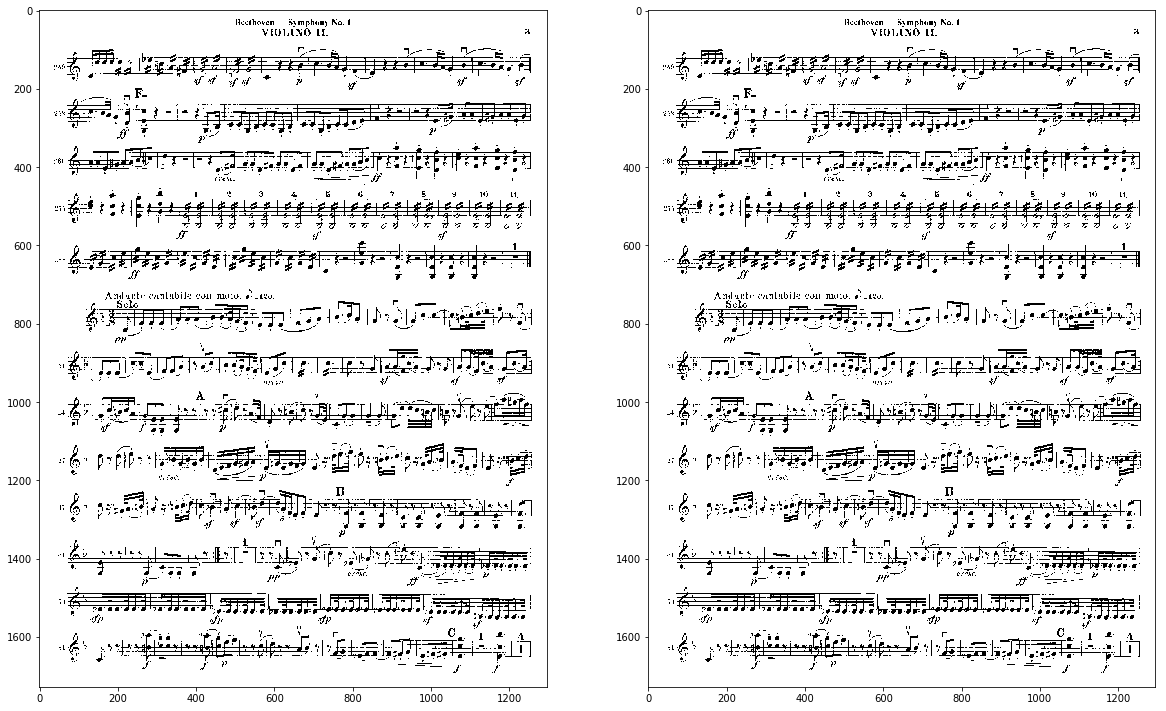

In [27]:
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(img_a, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img_b, cmap='gray')
plt.show()

In [28]:
_, img1 = cv2.threshold(img_a,127,255,cv2.THRESH_BINARY)
_, img2 = cv2.threshold(img_b,127,255,cv2.THRESH_BINARY)
if img1.shape[0] >= 1000:
    scale1 = 1.0 / (img1.shape[0] // 1000)
    img1 = cv2.resize(img1, (0,0), fx=scale1, fy=scale1)
if img2.shape[0] >= 1000:
    scale2 = 1.0 / (img2.shape[0] // 1000)
    img2 = cv2.resize(img2, (0,0), fx=scale2, fy=scale2)
img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB)

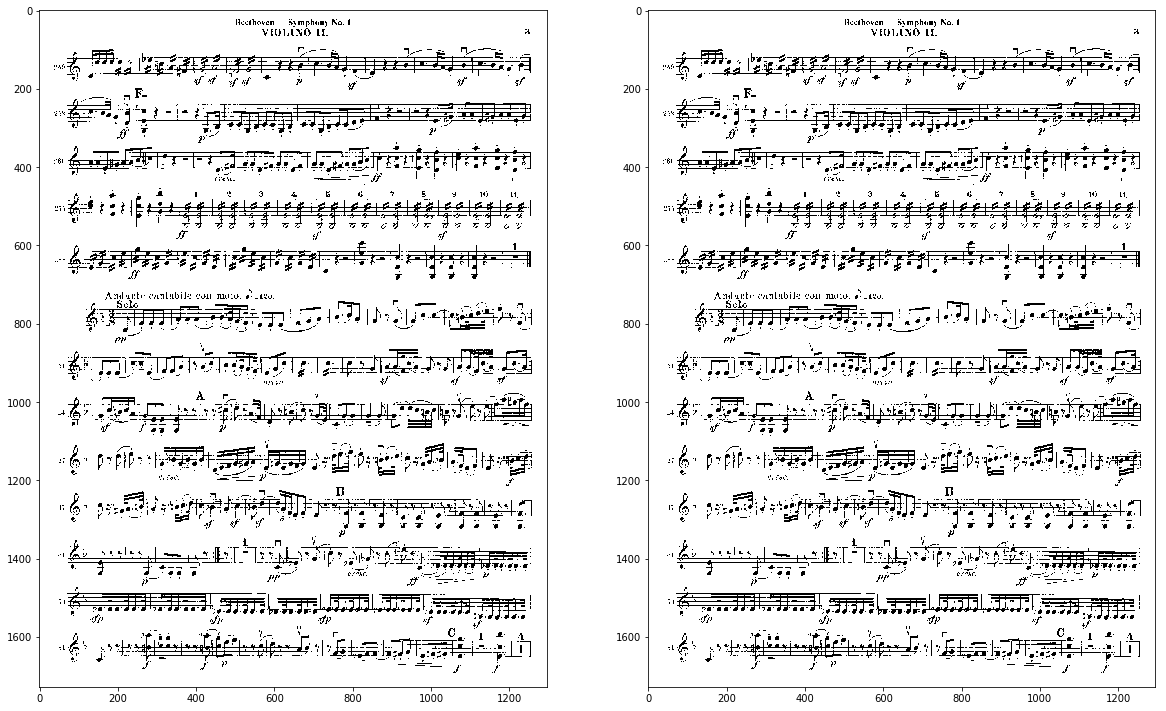

In [29]:
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(img1, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img2, cmap='gray')
plt.show()

In [30]:
matches = dm.deepmatching(img1, img2, '-downscale 3 -nt 12' )

In [31]:
len(matches)

2067

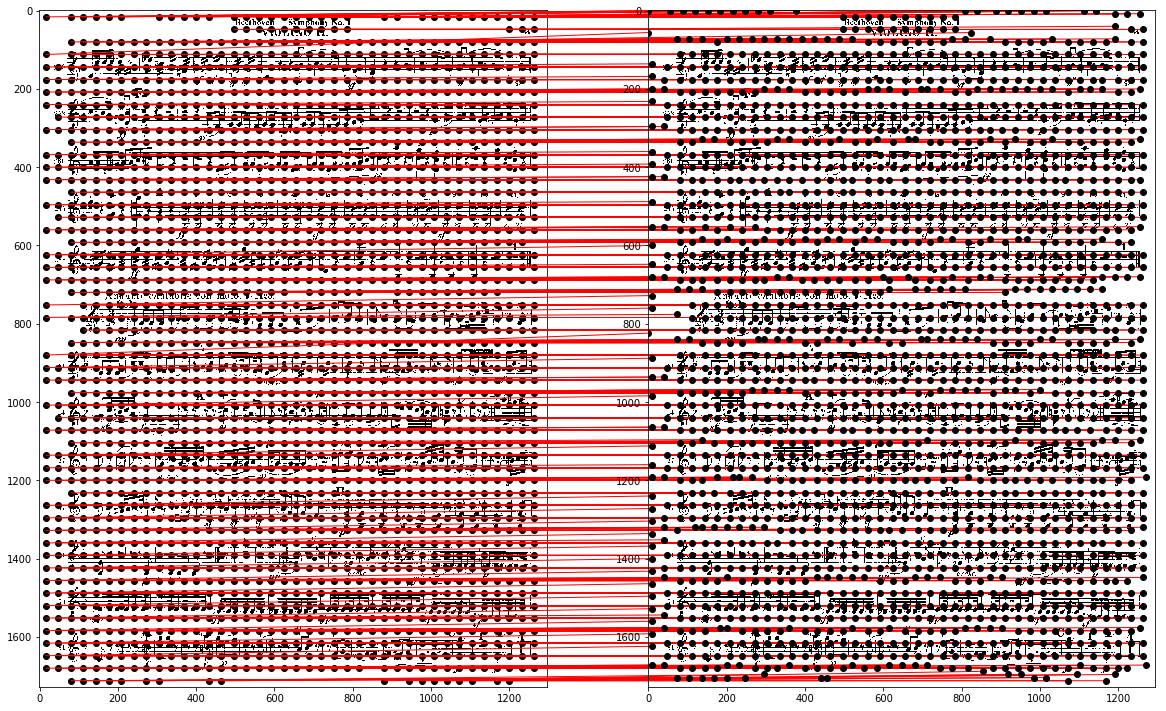

In [32]:
fig = plt.figure(figsize=(20,20))

ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img1)
for i in range(len(matches)):
    ax1.plot([matches[i][0]], [matches[i][1]], 'ko')
           
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(img2)
for i in range(len(matches)):
    ax2.plot([matches[i][2]], [matches[i][3]], 'ko')

for i in range(len(matches)):
    con = ConnectionPatch(xyA=(matches[i][2], matches[i][3]), coordsA='data', coordsB='data',
                          xyB=(matches[i][0], matches[i][1]), axesA=ax2, axesB=ax1, color='red')
    ax2.add_artist(con)